# **Homework 6: Neural networks and variational autoencoders (VAEs)**
STAT 348, UChicago, Spring 2025

----------------
**Your name here:**

**Hours spent:**

(Please let us know how many hours in total you spent on this assignment so we can calibrate for future assignments. Your feedback is always welcome!)

----------------

<a href="https://colab.research.google.com/github/aschein/stat_348_2025/blob/main/assignments/hw6/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

This homework focuses on themes in lecture 14 on neural networks, automatic differentiation, variational autoencoders, and amortized variational inference.

For this homework you will have to learn how to build and train neural networks using automatic differentiation in PyTorch, and then use them to build a variational autoencoder. There are many resources available to you online including:
- [Neural networks in PyTorch](https://docs.pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)
- [A gentle introduction to torch.autograd](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
- [This notebook on neural networks and VAEs](https://github.com/slinderman/stats305c/blob/spring2023/notebooks/12_nns_vaes.ipynb)

For reference, this homework is a close adaption of [HW6 for Scott Linderman's STATS 305C](https://github.com/slinderman/stats305c/blob/spring2023/assignments/hw6/hw6.ipynb).

Assignment is due **Wednesday May 21, 11:59pm** on GradeScope.

In [3]:
from getpass import getpass
token = getpass('Your token:')
!git clone https://{token}@github.com/Zijiang-Yang/STAT_34800.git
%cd /content/STAT_34800/assignments/hw6
!git pull

Your token:··········
fatal: destination path 'STAT_34800' already exists and is not an empty directory.
/content/STAT_34800/assignments/hw6
Already up to date.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Uniform
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import numpy as np
import math
from tqdm.notebook import tqdm

torch.manual_seed(305)

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")

## Problem 1: Optimizing a Quadratic Objective via Gradient Descent

We'll start off by optimizing a simple objective using gradient descent. We will compute the required gradients using **PyTorch's automatic differentation** capabilities.

Consider the function $f: \mathbb{R}^D \to \mathbb{R}$ given by:

$$ f(\mathbf{x}) = \mathbf{x}^\top \mathbf{A} \mathbf{x} $$

where $\mathbf{A} \in \mathbb{R}^{D \times D}$ is a fixed positive definite matrix. It is obvious that a global minimizer of $f$ is $\mathbf{x}^* = 0$. We will try to recover this known global minimizer using gradient descent. We note that although the objective is seemingly simple, a stochastic version of this objective has been used as a model for neural network loss surfaces (e.g. see [this paper](https://arxiv.org/abs/1803.02021)).

We will simplify the objective further by assuming that $\mathbf{A}$ is diagonal, so $\mathbf{A} = \text{diag}(\mathbf{a})$ for some $\mathbf{a} \in \mathbb{R}_{+}^D$.

### Problem 1a: Gradient descent with a well-conditioned objective

Recall the gradient descent update rule for a fixed step size $\alpha$ is:

$$\mathbf{x}^{(k + 1)} \gets \mathbf{x}^{(k)} - \alpha \nabla f(\mathbf{x}^{(k)})$$

Using PyTorch's automatic differentiation system, complete the function below implementing an optimization loop to minimize the objective.

In [6]:
def f(x, a):
    """ Evaluates the objective.

    Args:
        x: (D,) tensor
        a: (D,) tensor of positive values
    Returns:
        value: (,) tensor
    """
    return (a * x**2).sum()

def run_optimization(x, a, optimizer, num_iters):
    """ Runs an optimization algorithm on the objective for num_iters.

    Args:
        x: Starting position for optimization. nn.Parameter of shape (D,)
        a: parameter defining curvature of objective. tensor of shape (D,)
        optimizer: a torch.optim Optimizer
        num_iters: number of iterations to run optimization for

    Returns:
        xs: value of x at each iteration. tensor of shape (num_iters + 1, D)
        losses: value of objective at each iterate. tensor of shape (num_iters + 1,)
    """
    losses = []
    # we have to make a copy of the data so that elements of list do not
    # reference same location in memory
    xs = [x.data.clone()]

    for it in range(num_iters):

        optimizer.zero_grad()
        loss = f(x, a)
        loss.backward()
        optimizer.step()

        losses.append(loss)
        xs.append(x.data.clone())

    # Return the stacked losses and xs
    losses = torch.tensor(losses)
    xs = torch.vstack(xs)
    return xs, losses

We will now run gradient descent on the objective in $D = 2$ dimensions, with $\mathbf{a} = (0.2, 0.2)$. We will use 50 iterations with a learning rate of $\alpha = 0.8$, starting from $\mathbf{x}_0 = (10, 10)$.

Note that we initialize `x` using `nn.Parameter`, which tells PyTorch we need to compute gradients with respect to `x`. Note that PyTorch's optimizers expect an iterable of `Parameters` to be passed as the first argument, so you must pass in `[x]` rather than `x` itself.

In [7]:
D = 2
x = nn.Parameter(10 * torch.ones(D))
a = 0.2 * torch.ones(D)
learning_rate = 0.8
num_iters = 50

optimizer = torch.optim.SGD([x], lr=learning_rate)
xs, losses = run_optimization(x, a, optimizer, num_iters)

Let's plot the loss curve. As you can see, the objective approaches the optimal value of zero quite quickly.

Text(0, 0.5, 'Objective Value')

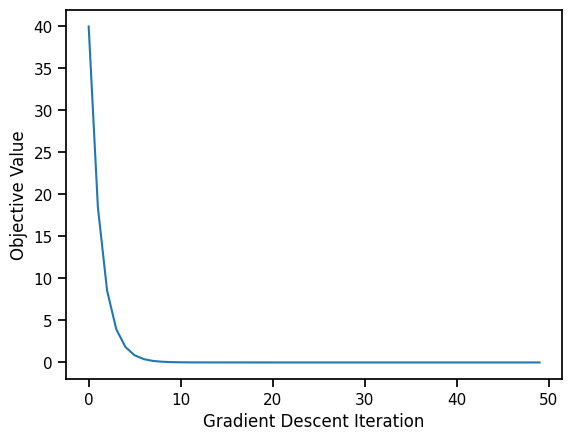

In [8]:
plt.figure()
plt.plot(losses)
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Objective Value")

Next, let's visualize the trajectory of the gradient descent iterates $\mathbf{x}^{(k)}$.

In [9]:
def visualize_gradient_descent(xs, a, width=12, grid_size=200):
    """ Visualizes gradient descent when iterates are two-dimensional."""

    def batch_f(X):
        """
        Args:
            X: (N, D) tensor
        """
        return (X**2 * a).sum(dim=1)

    grid_size = 200
    x1s = np.linspace(-width, width, grid_size)
    x2s = np.linspace(-width, width, grid_size)
    X1, X2 = np.meshgrid(x1s, x2s)
    points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
    points = torch.tensor(points, dtype=torch.float)

    Z = batch_f(points).reshape(grid_size, grid_size)

    fig = plt.figure(figsize = (10,7))
    contours = plt.contour(X1, X2, Z, 20)

    plt.plot(xs[:,0], xs[:,1])
    plt.plot(xs[:,0], xs[:,1], '*', label = "Cost function")

    plt.xlabel('$x_1$', fontsize=15)
    plt.ylabel('$x_2$', fontsize=15)
    plt.show()

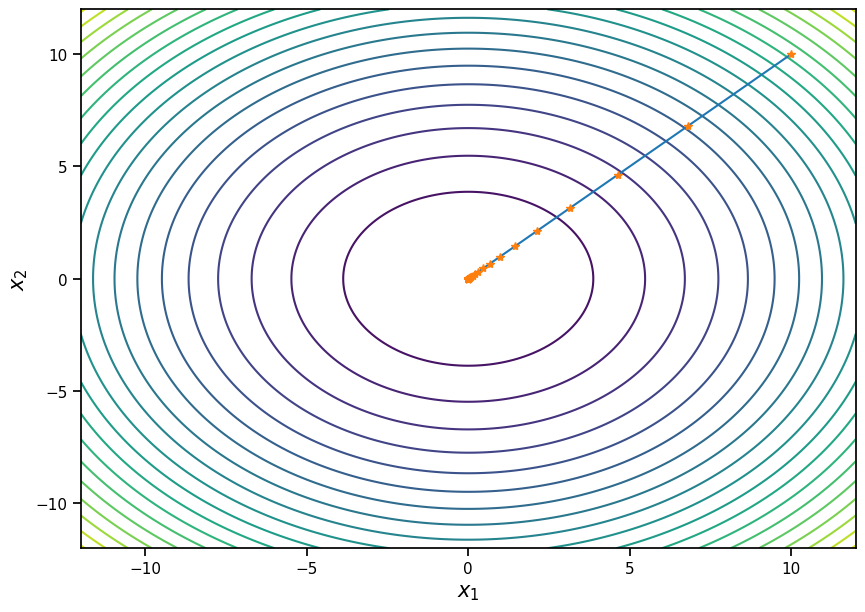

In [10]:
visualize_gradient_descent(xs, a)

### Problem 1b: Gradient Descent with an ill-conditioned objective

Next, let's see how gradient descent performs on an ill-conditioned objective, where the amount of curvature in each direction varies. For our objective, we can control the amount of curvature using $\mathbf{a}$. Repeat part (a), this time using $\mathbf{a} = (0.05, 1.2)$ while holding all other hyperparameters constant.

In [11]:
x = nn.Parameter(10 * torch.ones(D))
a = torch.tensor([0.05, 1.2])

learning_rate = 0.8
num_iters = 50

optimizer = torch.optim.SGD([x], lr=learning_rate)
xs, losses = run_optimization(x, a, optimizer, num_iters)

Text(0, 0.5, 'Objective Value')

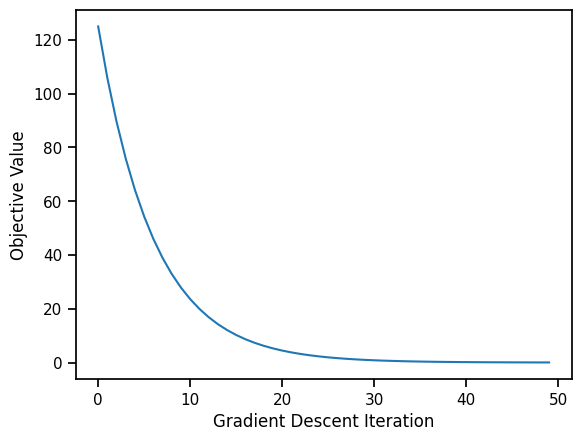

In [12]:
plt.figure()
plt.plot(losses)
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Objective Value")

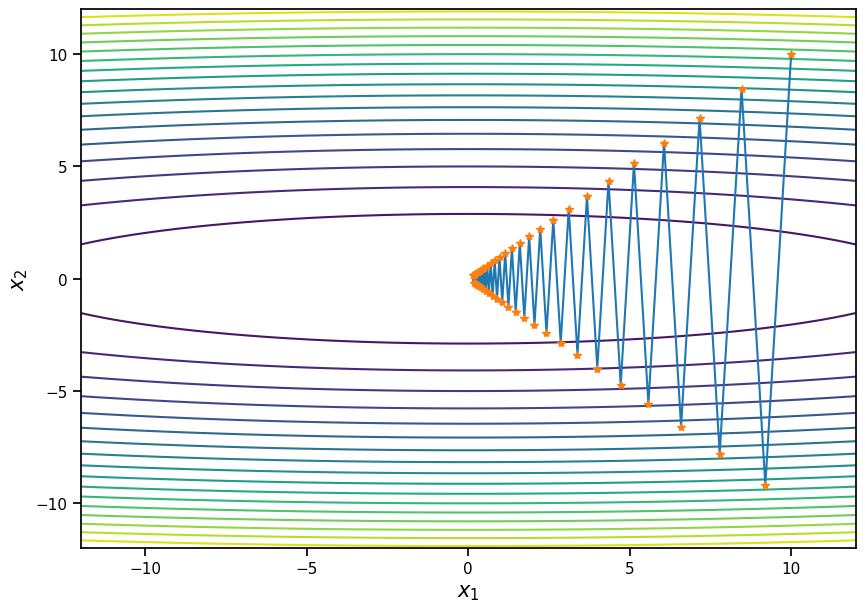

In [13]:
visualize_gradient_descent(xs, a)

Explain why the gradient descent iterates oscillate around the line $\mathbf{x}_2 = 0$ and suggest one change that could be made to eliminate this behavior, without changing the objective itself.

---

*Your answer here.*

We observe that the objective function is highly stretched: the $x_1$ direction is very flat and the other ($x_2$) is steep. Thus, the gradient in $x_2$ is large compared to $x_1$ ar the same value, then the updates in $x_2$ alternate signs and oscillate around zero. Meanwhile, $x_1$ updates slowly due to the samll gradient.

---

### Problem 1c: Optimizing a High-Dimensional Objective

Now let's tackle a more challenging, higher-dimensional problem. We'll use the same objective, but this time use $\mathbf{a} \in \mathbb{R}^{10}$ where:

$$a_i = 10^{-2 + \frac{4(i - 1)}{9}}$$

for $i \in \{1, \dots, 10\}$. This means the curvature of the dimensions ranges from $0.01$ to $100$.

Experiment with different optimizers and hyperparameter settings on this problem, starting from the initial point $x^{(0)} = (10, \dots, 10)$ and run your chosen optimizer for $1000$ iterations. You can see a complete list of optimizers PyTorch has implemented [here](https://pytorch.org/docs/stable/optim.html#algorithms). Find an optimizer/hyperparameter regime that achieves a final loss of less than $0.01$.

In [29]:
x = nn.Parameter(10 * torch.ones(10))
a = torch.tensor([10**i for i in np.linspace(-2, 2, num=10)])

optimizer = torch.optim.Adam([x], lr=0.1)
xs, losses = run_optimization(x, a, optimizer, 1000)

Text(0, 0.5, 'Objective Value')

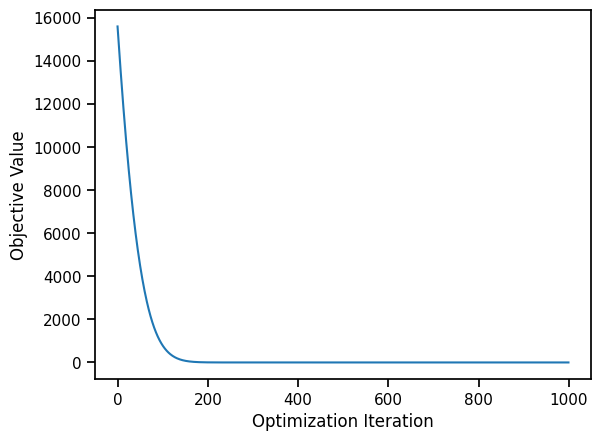

In [30]:
plt.figure()
plt.plot(losses)
plt.xlabel("Optimization Iteration")
plt.ylabel("Objective Value")

In [31]:
print("Final loss: {:.10f}".format(losses[-1].item()))

Final loss: 0.0000000000


## Problem 2: Neural Network Classification

Next, we will use a neural network to solve a classification problem for which the data is not linearly separable. We will implement the network as a PyTorch `nn.module` and train it using gradient descent, computing gradients using automatic differentation.

First, we create and visualize a two-dimensional dataset where each point is labeled as positive (1) or negative (0). As seen below, the positive and negative points are not linearly separable.


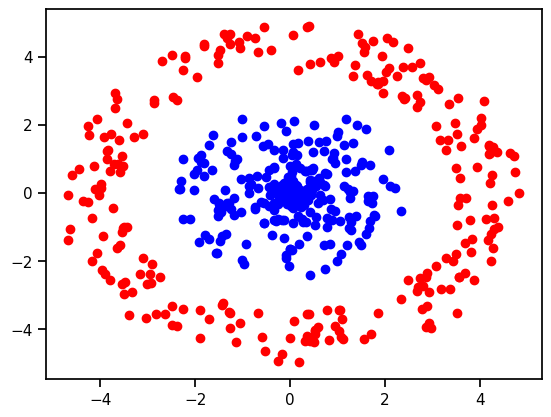

In [32]:
torch.manual_seed(305)

def make_dataset(num_points):
    radius = 5

    def sample_annulus(inner_radius, outer_radius, num_points):
        r = Uniform(inner_radius, outer_radius).sample((num_points,))
        angle = Uniform(0, 2 * math.pi).sample((num_points,))
        x = r * torch.cos(angle)
        y = r * torch.sin(angle)
        data = torch.vstack([x, y]).T
        return data

    # Generate positive examples (labeled 1)
    data_1 = sample_annulus(0, 0.5 * radius, num_points // 2)
    labels_1 = torch.ones(num_points // 2)

    # Generate negative examples (labeled 0).
    data_0 = sample_annulus(0.7 * radius, radius, num_points // 2)
    labels_0 = torch.zeros(num_points // 2)

    data = torch.vstack([data_0, data_1])
    labels = torch.concat([labels_0, labels_1])

    return data, labels

num_data = 500
data, labels = make_dataset(num_data)

# Note: red indicates a label of 1, blue indicates a label of 0
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red')
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue')

### Problem 2a: The Maximum Likelihood Objective

We will try to classify this data using a neural network. We posit the following statistical model for the labels $y \in \{0, 1\}$ given features $\mathbf{x} \in \mathbb{R}^2$:

$$ y \mid x \sim \text{Bern}(\sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x})))$$

Here, $\text{NN}_{\boldsymbol{\theta}}: \mathbb{R}^2 \to \mathbb{R}$ denotes a neural network with parameters $\boldsymbol{\theta} \in \mathbb{R}^P$ mapping datapoints $\mathbf{x}$ to $\text{logit}(\mathbb{P}(y = 1 \mid \mathbf{x}))$. Recall the [logit](https://en.wikipedia.org/wiki/Logit) function is given by

$$\text{logit}(p) = \log \left( \frac{p}{1-p} \right)$$

and its inverse is the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function):

$$\sigma(x) = \frac{1}{1 + \exp (-x)}$$

We estimate the parameters $\boldsymbol{\theta}$ using maximum likelihood. Show that for a dataset $\{(\mathbf{x}_n, y_n)\}_{n=1}^N$ the negative log-likelihood objective, rescaled by the number of datapoints $N$, may be written as:

$$ L(\boldsymbol{\theta}) = \frac{1}{N} \sum_{n = 1}^N -y_n \log \sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x})) - (1 - y_n) \log (1 -
 \sigma(\text{NN}_{\boldsymbol{\theta}}(\mathbf{x}))) = \frac{1}{N} \sum_{n = 1}^N \ell(y, \text{NN}_{\boldsymbol{\theta}}(\mathbf{x}_n))
$$

where $\ell(y, x) = -y \log \sigma(x) - (1 - y) \log(1 - \sigma(x))$.

---

*Your answer here.*

$$
\begin{align*}
L(\theta) &= \frac{1}{N}\sum_{n=1}^{N}-\log p(y_n|x_n)\\
&= \frac{1}{N}\sum_{n=1}^{N}-\log (\sigma(NN_{\theta}(x_n))^{y_n}(1-\sigma(NN_{\theta}(x_n))^{1-y_n})\\
&= \frac{1}{N}\sum_{n=1}^{N} -y_n \log(\sigma(NN_{\theta}(x_n))-(1-y_n)\log(1-\sigma(NN_{\theta}(x_n))\\
&= \frac{1}{N}\sum_{n=1}^{N} \ell(y_n, NN_{\theta}(x_n))
\end{align*}
$$

---

### Problem 2b: Define the Neural Network

We will use a neural network with two hidden layers, the first of which has three hidden units and the second of which has five hidden units. The equations defining the output $z \in \mathbb{R}$ of our neural network given an input $\mathbf{x} \in \mathbb{R}^2$ are:

$$
\begin{align*}
\mathbf{h}_1 &= \text{ReLU}(\mathbf{W_1} \mathbf{x} + \mathbf{b_1}) \\
\mathbf{h}_2 &= \text{ReLU}(\mathbf{W_2} \mathbf{h}_1 + \mathbf{b_2}) \\
z &= \mathbf{w}_3^\top \mathbf{h}_2 + b_3
\end{align*}
$$

The parameters of the network are $\boldsymbol{\theta} = (\mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2, \mathbf{w}_3, b_3)$ where $\mathbf{W}_1 \in \mathbb{R}^{3 \times 2}, \mathbf{b}_1 \in \mathbb{R}^3, \mathbf{W}_2 \in \mathbb{R}^{5 \times 3}, \mathbf{b}_2 \in \mathbb{R}^5, \mathbf{w}_3 \in \mathbb{R}^5$, and $b_3 \in \mathbb{R}$.

Implement this network as a PyTorch `nn.Module` using `nn.Linear` and `F.relu`.

In [33]:
class SimpleNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        """ Implements the forward pass of the network.

        Args:
            x: torch.tensor of shape (N, 2)
        Returns:
            logits: torch.tensor of shape (N,) containing the logits
        """
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        logits = self.fc3(h2).squeeze()
        return logits

Let's visualize the predictions of an untrained network. As we can see, the network does not succeed at classifying the points without training



<ipython-input-34-732379c2d87e>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.pcolormesh(X1, X2, probs, cmap=plt.cm.get_cmap('YlGn'), vmin=0, vmax=1)


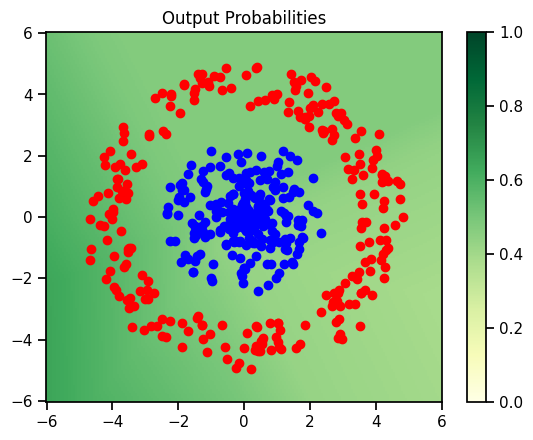

In [34]:
def visualize_predictions(net):
    num_points = 200
    x1s = np.linspace(-6.0, 6.0, num_points)
    x2s = np.linspace(-6.0, 6.0, num_points)
    X1, X2 = np.meshgrid(x1s, x2s)

    points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
    points = torch.tensor(points, dtype=torch.float)
    with torch.no_grad():
        probs = torch.sigmoid(net(points)).reshape(num_points, num_points)

    plt.pcolormesh(X1, X2, probs, cmap=plt.cm.get_cmap('YlGn'), vmin=0, vmax=1)
    plt.colorbar()
    plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red')
    plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue')
    plt.title("Output Probabilities")

torch.manual_seed(305)
model = SimpleNet()
visualize_predictions(model)

### Problem 2c: Train the Network

We will now find the parameters of our network by maximizing the likelihood, or equivalently minimizing the negative log-likelihood. We will use full-batch gradient descent. That is, we will use the gradient $\nabla L(\boldsymbol{\theta})$ itself to update the parameters rather than a stochastic estimate of $\nabla L(\boldsymbol{\theta})$.

Use the SGD optimizer from `torch.optim` with a learning rate of $1$ and no momentum for 1000 iterations. Note that the function $\ell$ from above is implemented in PyTorch as [`nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

In [36]:
num_steps = 1000
losses = []

# YOUR CODE HERE
def nll_loss(y_true, logits):
  probs = torch.sigmoid(logits)
  return torch.mean(-y_true * torch.log(probs + 1e-8) - (1 - y_true) * torch.log(1 - probs + 1e-8))

model = SimpleNet()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

for it in tqdm(range(num_steps)):
  optimizer.zero_grad()

  logits = model(data)              # shape: (N,)
  loss = nll_loss(labels, logits)     # custom NLL loss

  loss.backward()
  optimizer.step()
  losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'Objective Value')

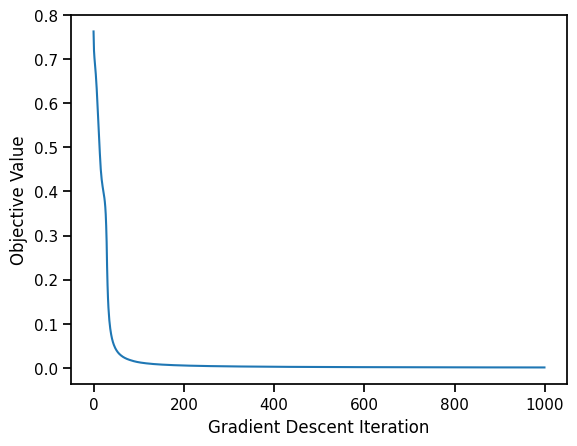

In [37]:
plt.figure()
plt.plot(losses)
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Objective Value")

Let's visualize the predictions of our trained network. We see that the network has learned to separate the positive and negative examples.

<ipython-input-34-732379c2d87e>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.pcolormesh(X1, X2, probs, cmap=plt.cm.get_cmap('YlGn'), vmin=0, vmax=1)


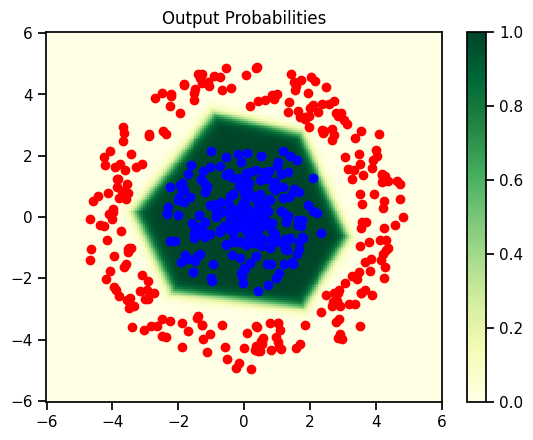

In [38]:
visualize_predictions(model)

## Problem 3: Amortized Variational Inference

In this problem, we will train a variational autoencoder for the MNIST dataset of handwritten digits. First, let's download this dataset using PyTorch's `datasets` module and visualize some of the digits. We will use a binarized version of the dataset in which each pixel value is either 0 or 1.

In [39]:
# Download MNIST dataset and create dataloaders.
def binarize(imgs, integer=False):
    threshold = 127 if integer else 0.5
    imgs = imgs.clone()
    imgs[imgs < threshold] = 0.
    imgs[imgs >= threshold] = 1.
    return imgs

train_dataset = datasets.MNIST(root="data", train=True, download=True,
                         transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='data', train=False, download=True,
                             transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of points in dataset: {0}".format(train_dataset.data.shape[0]))
print("Number of batches per epoch: {0}".format(len(train_loader)))

100%|██████████| 9.91M/9.91M [00:00<00:00, 124MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 28.4MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 98.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.44MB/s]


Number of points in dataset: 60000
Number of batches per epoch: 938


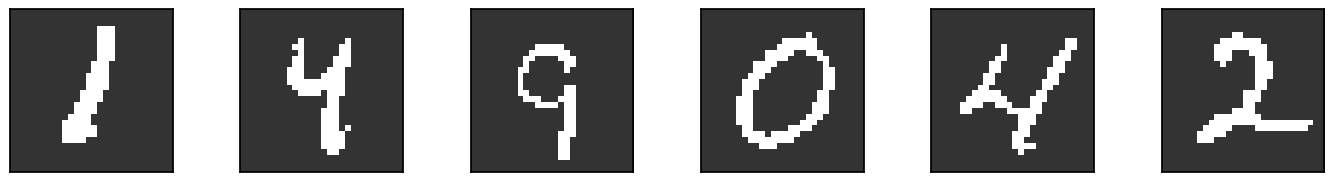

In [40]:
# Visualize some digits in the dataset.
imgs, _ = next(iter(train_loader))
imgs = binarize(imgs)
fig, ax = plt.subplots(1, 6, figsize=(14, 14))
fig.tight_layout()
for i, ax in enumerate(ax.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(imgs[i].squeeze(), alpha=0.8, cmap='gray')

### Problem 3a: Decoder Network

We represent a $28 \times 28$ image $\mathbf{x}$ as a flattened $784$ dimensional vector of binary values, i.e. $\mathbf{x} \in \{0, 1\}^{784}$. We specify our generative model as:

$$ \mathbf{z} \sim \mathcal{N}(0, I), \quad \mathbf{x} \mid \mathbf{z} \sim \text{Bern}(\sigma(D_{\boldsymbol{\theta}}(\mathbf{z}))$$

Here, $D_{\boldsymbol{\theta}}: \mathbb{R}^2 \to \mathbb{R}^{784}$ is a neural network with parameters $\boldsymbol{\theta}$ and $\mathbf{z} \in \mathbb{R}^{2}$ is a two-dimensional latent variable. We use only two dimensions so that the latent space can be easily visualized later, but using a higher dimensional latent variable would give a more flexible generative model.

We will parametrize $D_{\boldsymbol{\theta}}$ as a fully connected neural network with two hidden layers and ReLU activations. We use 256 units in the first hidden layer and 512 in the second. Note that as in Problem 2, the network maps to the logits of the Bernoulli distribution and not the probabilities themselves. Implement this decoder network in PyTorch below.

In [41]:
# Define decoder architecture
class Decoder(nn.Module):
    """ Neural network defining p(x | z) """

    def __init__(self, data_dim, latent_dim, hidden_dims=[256, 512]):
        super().__init__()
        self.data_dim = data_dim

        # YOUR CODE HERE
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], data_dim)  # output logits (not probabilities)
        )

    def forward(self, z):
        """ Returns Bernoulli conditional distribution of p(x | z), parametrized
        by logits.
        Args:
            z: (N, latent_dim) torch.tensor
        Returns:
            Bernoulli distribution with a batch of (N, data_dim) logits
        """
        # YOUR CODE HERE
        logits = self.net(z)
        return Bernoulli(logits=logits)

### Problem 3b: Encoder Network

We will estimate the parameters of the generative model by maximizing the Evidence Lower Bound (ELBO). As the exact posterior $p(\mathbf{z} \mid \mathbf{x})$ is unknown, we will use an approximate, amortized posterior $q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) = \mathcal{N}(\mathbf{z} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}), \text{diag}(\sigma^2_{\boldsymbol{\phi}}(\mathbf{x})))$. We let $\left(\mu_{\boldsymbol{\phi}}(\mathbf{x}), \log \sigma^2_{\boldsymbol{\phi}}(\mathbf{x}) \right) = E_{\boldsymbol{\phi}}(\mathbf{x})$ where $E_{\boldsymbol{\phi}}: \mathbb{R}^{784} \to \mathbb{R}^2 \times \mathbb{R}^2$ is a neural network with parameters $\boldsymbol{\phi}$.

As above, we parametrize $E_{\boldsymbol{\phi}}$ as a neural network with two layers of hidden units and ReLU activations. We use 512 hidden units in the first layer and 256 in the second. Then we let $\mu_{\boldsymbol{\phi}}$ and $\log \sigma^2_{\boldsymbol{\phi}}$ be affine functions of the hidden layer activations. Implement the encoder $E_{\boldsymbol{\phi}}$ in the code below.

In [42]:
# Define encoder architecture
class Encoder(nn.Module):
    """ Neural network defining q(z | x). """

    def __init__(self, data_dim, latent_dim, hidden_dims=[512, 256]):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(data_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )

        self.mu_layer = nn.Linear(hidden_dims[1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dims[1], latent_dim)

    def forward(self, x):
        """ Returns Normal conditional distribution for q(z | x), with mean and
        log-variance output by a neural network.

        Args:
            x: (N, data_dim) torch.tensor
        Returns:
            Normal distribution with a batch of (N, latent_dim) means and standard deviations
        """
        hidden = self.net(x)
        mu = self.mu_layer(hidden)
        logvar = self.logvar_layer(hidden)
        std = torch.exp(0.5 * logvar)  # std = sqrt(σ²)
        return Normal(loc=mu, scale=std)

### ELBO Derivation [given]

As a function of $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$, we can write the ELBO for a single datapoint $\mathbf{x}$ as:

$$\mathcal{L}(\mathbf{x}, \boldsymbol{\theta}, \boldsymbol{\phi}) = \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z}) - \log q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \right]$$

We can obtain a lower bound of the log-likelihood for an entire dataset $\{\mathbf{x}^{(n)} \}_{n=1}^N$, rescaled by the number of datapoints $N$, as:

$$\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}) = \frac{1}{N} \sum_{n=1}^N \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}^{(n)} \mid \mathbf{x}^{(n)})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x}^{(n)}, \mathbf{z}^{(n)}) - \log q_{\boldsymbol{\phi}}(\mathbf{z}^{(n)} \mid \mathbf{x}^{(n)}) \right]$$

We can rewrite the per-datapoint ELBO as:

$$
\begin{align*}
\mathcal{L}(\mathbf{x}, \boldsymbol{\theta}, \boldsymbol{\phi})
&= \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z}) \right] - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right) \\
&= \mathbb{E}_{\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})} \left[ \log p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}) + \boldsymbol{\epsilon} \odot \sigma_{\boldsymbol{\phi}}(\mathbf{x})) \right] - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)
\end{align*}
$$

This allows us to obtain an unbiased estimate of the per-datapoint ELBO by first sampling $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, then computing:

$$\hat{\mathcal{L}}(\mathbf{x}, \boldsymbol{\theta}, \boldsymbol{\phi}) = \log p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}) + \boldsymbol{\epsilon} \odot \sigma_{\boldsymbol{\phi}}(\mathbf{x})) - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)$$

This is known as the reparametrization trick, and it will allow us to straightforwardly use automatic differentiation to obtain the gradient of $\hat{\mathcal{L}}$ with respect to $\boldsymbol{\phi}$.

Given a minibatch $\{\mathbf{x}^{(b)} \}_{b=1}^B$ sampled uniformly from the entire dataset, we can simulate independent normal variates $\boldsymbol{\epsilon}^{(b)}$ to form an unbiased estimator of the ELBO for the entire dataset:

$$\hat{\mathcal{L}}(\boldsymbol{\theta}, \boldsymbol{\phi}) = \frac{1}{B} \sum_{b = 1}^B \log p_{\boldsymbol{\theta}}(\mathbf{x}^{(b)} \mid \mu_{\boldsymbol{\phi}}(\mathbf{x}^{(b)}) + \boldsymbol{\epsilon} \odot \sigma_{\boldsymbol{\phi}}(\mathbf{x}^{(b)})) - \text{KL}\left( q_{\boldsymbol{\phi}}(\mathbf{z}^{(b)} \mid \mathbf{x}^{(b)}) \mid\mid p(\mathbf{z}^{(b)})\right) $$

### Problem 3c: Implement the ELBO

Using our derivations above, implement the estimator of the ELBO $\hat{\mathcal{L}}(\boldsymbol{\theta}, \boldsymbol{\phi})$. We assume sampling of the minibatch `x` is done outside of the function, but you must sample the noise variables $\boldsymbol{\epsilon}$ within the `elbo` function. You should use the `kl_divergence` function imported above to analytically compute the KL divergence between the Gaussian distributions $q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})$ and $p(\mathbf{z})$. Make sure you use `rsample` on a `Distribution` object to use the reparametrization trick and not `sample`.

In [51]:
def elbo(x, encoder, decoder):
  """ Computes a stochastic estimate of the rescaled evidence lower bound

  Args:
      x: (N, data_dim) torch.tensor
      encoder: an Encoder
      decoder: a Decoder
  Returns:
      elbo: a (,) torch.tensor containing the estimate of the ELBO
  """
  q_z_given_x = encoder(x)

  z = q_z_given_x.rsample()

  # bernoulli_logits = decoder(z)
  # p_x_given_z = Bernoulli(logits=bernoulli_logits)

  p_x_given_z = decoder(z)

  log_likelihood = p_x_given_z.log_prob(x).sum(dim=1)

  p_z = Normal(loc=torch.zeros_like(z), scale=torch.ones_like(z))

  kl = kl_divergence(q_z_given_x, p_z).sum(dim=1)

  elbo_batch = log_likelihood - kl

  return elbo_batch.mean()


### Implement the Training Loop [given]

Using our `Encoder` and `Decoder` definitions, as well as the `elbo` function, we have provided training code below. This code uses the [Adam](https://arxiv.org/abs/1412.6980) optimizer, a sophisticated optimization algorithm which uses the history of past gradients to rescale gradients before applying an update.

We train for 20 epochs (an "epoch" refers to a complete pass through the dataset). Our implementation takes 10 minutes to run and achieves a training ELBO of $-135$ and a test ELBO of $-138$.

In [52]:
encoder = Encoder(data_dim=784, latent_dim=2)
decoder = Decoder(data_dim=784, latent_dim=2)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                       lr=3e-4)

num_epochs = 20

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_elbo = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = binarize(x.reshape(x.shape[0], -1))
        optimizer.zero_grad()

        loss = -elbo(x, encoder, decoder)
        loss.backward()
        train_elbo -= loss.item() * len(x)
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tELBO: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), -loss.item()))

    encoder.eval()
    decoder.eval()
    test_elbo = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = binarize(x.reshape(x.shape[0], -1))#.cuda()
            test_elbo += elbo(x, encoder, decoder).item() * len(x)

    train_elbo /= len(train_loader.dataset)
    test_elbo /= len(test_loader.dataset)

    print('====> Epoch: {} Average ELBO: {:.4f} Test ELBO: {:.4f}'.format(epoch,
                                                                          train_elbo,
                                                                          test_elbo))


Train Epoch: 0 [0/60000 (0%)]	ELBO: -545.429688
Train Epoch: 0 [6400/60000 (11%)]	ELBO: -205.921463
Train Epoch: 0 [12800/60000 (21%)]	ELBO: -190.128296
Train Epoch: 0 [19200/60000 (32%)]	ELBO: -190.180725
Train Epoch: 0 [25600/60000 (43%)]	ELBO: -176.720596
Train Epoch: 0 [32000/60000 (53%)]	ELBO: -181.749084
Train Epoch: 0 [38400/60000 (64%)]	ELBO: -162.861145
Train Epoch: 0 [44800/60000 (75%)]	ELBO: -167.080933
Train Epoch: 0 [51200/60000 (85%)]	ELBO: -154.513184
Train Epoch: 0 [57600/60000 (96%)]	ELBO: -150.227631
====> Epoch: 0 Average ELBO: -186.7524 Test ELBO: -165.5583
Train Epoch: 1 [0/60000 (0%)]	ELBO: -170.240723
Train Epoch: 1 [6400/60000 (11%)]	ELBO: -161.447052
Train Epoch: 1 [12800/60000 (21%)]	ELBO: -162.165833
Train Epoch: 1 [19200/60000 (32%)]	ELBO: -154.227570
Train Epoch: 1 [25600/60000 (43%)]	ELBO: -163.013184
Train Epoch: 1 [32000/60000 (53%)]	ELBO: -156.310074
Train Epoch: 1 [38400/60000 (64%)]	ELBO: -158.009232
Train Epoch: 1 [44800/60000 (75%)]	ELBO: -168.19334

### Problem 3d: Visualize samples from the trained model

In addition to the ELBO, we can sample from the trained model to assess its performance. Use the code below to generate an $8 \times 8$ grid of sampled digits from the model. Note that we follow the common practice of using the mean of $p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z})$ rather than resampling from this distribution when visualizing samples. Critique these samples. What aspects of the data distribution does the model seem to have trouble learning?

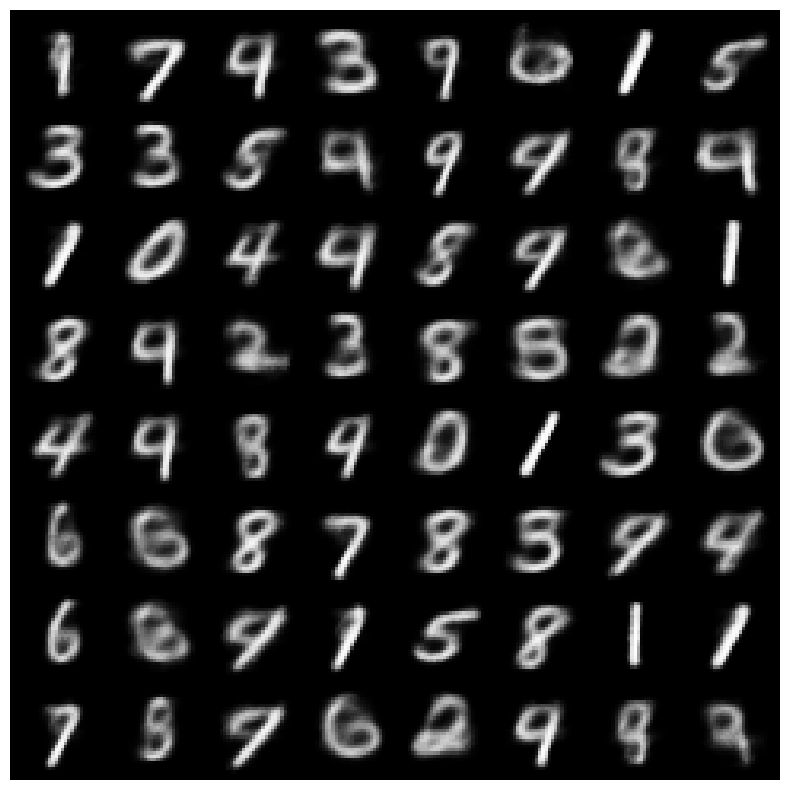

In [53]:
# Visualize sampled digits from our model
decoder.eval()

num_samples = 64
with torch.no_grad():
    z = torch.randn(num_samples, 2)
    expected_xs = decoder.forward(z).mean
    expected_xs = expected_xs.reshape(-1, 28, 28).unsqueeze(1)

# Plot the expected_xs as a grid of images
expected_xs_grid = make_grid(expected_xs, nrow=8)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(expected_xs_grid.permute(1, 2, 0), vmin=0., vmax=1.)
plt.show()

---

*Your answer here.*

Some digit have clear structure like "1" and "9".

However, some digits are very blurry like "6", "9" and "4". It is possible that the model lacks expressive capacity, training data has ambiguities or the decoder is not strong enough.

---

### Problem 3e: Visualize the Latent Embeddings

Given $\mathbf{x}$, we can interpret the mean of the approximate posterior $\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}[\mathbf{z}]$ as a lower dimensional representation of $\mathbf{x}$. In the code below, we find the mean of the approximate posterior for each of the datapoints in the dataset and then visualize these means with a scatter plot. We color each point according to the label of the encoded digit. What do you notice? Are there classes with significant overlap, and are these classes which are visually similar? Is there a class which has clear separation from the others, and if so, why do you think this is?

Note that we did not provide any information about the class label to either the generative model or the approximate posterior!

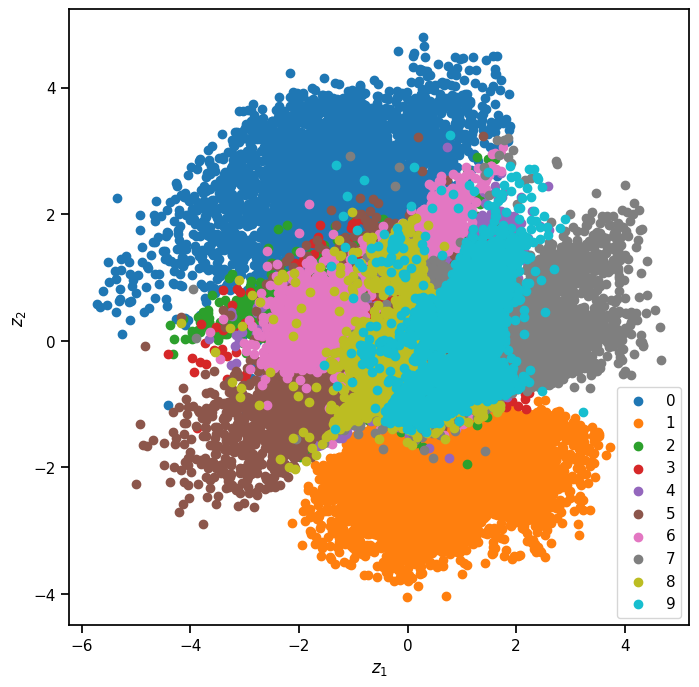

In [54]:
# Compute the mean of the latents given the data
encoder.eval()
with torch.no_grad():
    means = []
    ys = []
    for x, y in train_loader:
        x = binarize(x.reshape(x.shape[0], -1))
        mean = encoder.forward(x).mean
        means.append(mean)
        ys.append(y)

means = torch.vstack(means)
ys = torch.hstack(ys)

# Plot the first two dimensions of the latents
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(10):
    means_i = means[ys == i]
    ax.scatter(means_i[:, 0], means_i[:, 1], label=str(i))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.legend()

---

*Your answer here.*

Firstly, we notice that the latent z for digits "3", "5", "6" and "8" have significant overlap. These classes are also visaully similar.

Secondly, we observe that the latent z for digits "0", "1" and "7" are highly separated from others. It is obvious that they are visually different.

Despite not using any labels, the VAE learned semantically meaningful clusters based purely on pixel data and unsupervised learning. The KL regularization and Gaussian prior encourage the posterior means to spread out but remain near the origin, forming this dense layout.

---

### Problem 3f: Interpolation in the Latent Space

Another desideratum for a latent variable model is smooth interpolation in the latent space. For example, if we linearly interpolate between a latent $\mathbf{z}_{start}$ corresponding to a $7$ and a latent $\mathbf{z}_{end}$ corresponding to a $1$, we should observe the decodings of the interpolations smoothly change from a $7$ to a $1$.

In the code below, we sample $8$ different starting latent variables and $8$ different ending latent variables from the prior, linearly interpolate between them for $10$ points, then plot the decodings. Does our model smoothly change between decoded digits? Are there digit pairs it was more successful interpolating between?

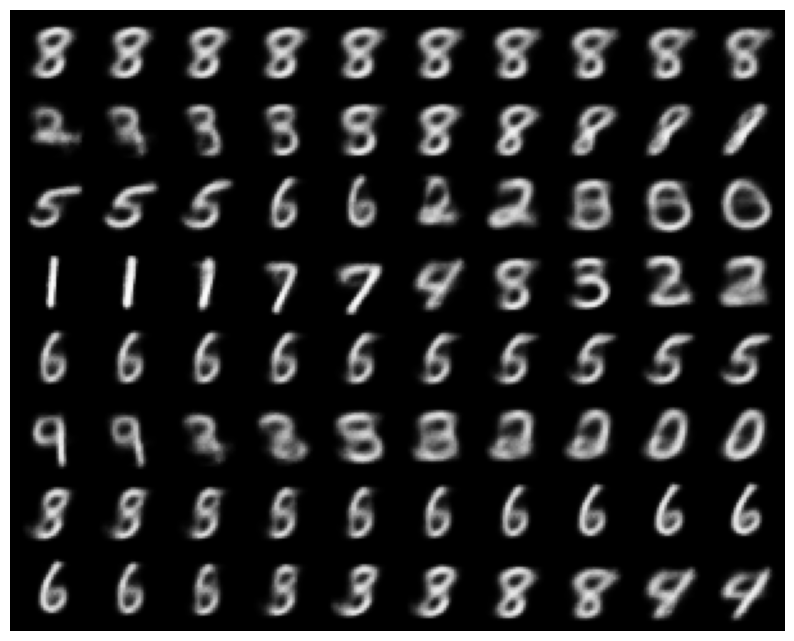

In [55]:
# Interpolate between 8 randomly chosen start and end points
latent_starts = torch.randn(8, 2)
latent_ends = torch.randn(8, 2)

means = []
for t in torch.linspace(0, 1, 10):
    z = latent_starts + t * (latent_ends - latent_starts)
    with torch.no_grad():
        means.append(decoder.forward(z).mean.reshape(-1, 28, 28).unsqueeze(0))

means_tensor = torch.vstack(means).permute(1, 0, 2, 3).reshape(-1, 28, 28).unsqueeze(1)
sample_grid = make_grid(means_tensor, nrow=10)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

---

*Your answer here.*

We observe that some pairs transfering smoothly like (6->5), (8->6), (2->8). But the transition is not very smooth between (1->2) and (5->0).

We can conclude that the transition is more possible to be smooth between to visually similar digits, but less likely happen between two digits with very seperate latent representations.

---

## Problem 4: Reflections

### Problem 4a

Discuss one reason why we use amortized variational inference rather than optimizing per-datapoint latent variables $\mu^{(n)}, (\boldsymbol{\sigma}^2)^{(n)}$ (so $p(\mathbf{z^{(n)}} \mid \mathbf{x}^{(n)})= \mathcal{N}(\mathbf{z}^{(n)} \mid \mu^{(n)}, \text{diag}((\boldsymbol{\sigma}^2)^{(n)})$).

---

*Your answer here.*

One major reason we use amortized variational inference is computational efficiency.

Optimizing per-datapoint latent variables $\mu^{(n)}$, $\boldsymbol{\sigma}^{(n)}$ directly would mean introducing new variational parameters for each datapoint. It requires storing and optimizing millions of separate parameters — one pair $(\mu^{(n)}, \boldsymbol{\sigma}^{(n)})$ per datapoint.

In contrast, amortized inference uses a single encoder network to predict $\mu^{(n)}$ and $\boldsymbol{\sigma}^{(n)}$ for any input $\mathbf{x}^{(n)}$.

---

### Problem 4b

Describe one way you could improve the variational autoencoder, either by changing the encoder or decoder network structure or by changing the  model itself, and why you think your proposed change would help.


---

*Your answer here.*

Instead of approximating the posterior $q_{\phi}(z|x)$ with a simple Gaussian, we define it as a transformed distribution:
$$
\mathbf{z}_K = f_K \circ f_{K-1} \circ \cdots \circ f_1(\mathbf{z}_0), \quad \mathbf{z}_0 \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2 \mathbf{I})
$$
where each $f_i$ is an invertible, differentiable transformation, and the density can be computed via the change of variables formula.

The standard VAE often underfits because the approximate posterior is too simple to match the true posterior well.

Normalizing flows provide a more flexible family of distributions to approximate the posterior, which reduces the variational gap , leads to better reconstructions and sharper generations and improves latent space structure and disentanglement.


---

### Problem 4c

Suppose rather than using a Gaussian prior on $\mathbf{z}$, we used $\mathbf{z} \overset{ind}{\sim} \text{Bern}(0.5)$. We can modify $E_{\boldsymbol{\phi}}$ to output logits for a multivariate Bernoulli distribution: $p(\mathbf{z} \mid \mathbf{x}; \boldsymbol{\phi}) = \text{Bern}(\mathbf{z}; \sigma(E_{\boldsymbol{\phi}}(\mathbf{x})))$. Where would our optimization procedure break down in this case?

---

*Your answer here.*

If $\mathbf{z} \sim \text{Bern}(0.5)$ and the encoder outputs logits for Bernoulli posteriors, then sampling from the posterior $q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x}) = \text{Bern}(\sigma(E_\phi(\mathbf{x})))$ becomes non-differentiable:

We can’t use the standard reparameterization trick (used for Gaussian posteriors) to backpropagate gradients through $\mathbf{z}$.

This breaks the ability to train the encoder network $E_\phi$ using stochastic gradient descent, as the gradient with respect to $\boldsymbol{\phi}$ becomes undefined or has high variance.

---

## Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

Download your notebook in .ipynb format and remove the Open in Colab button.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourname>_hw6.ipynb
```


**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf files to Gradescope.